In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math

# %matplotlib notebook
%matplotlib inline

# Метод стрельбы

In [52]:
def RungeKutta(ddy, dy0, y0, x, h):
    y = [0 for i in range(len(x))]
    z = [0 for i in range(len(x))]
    y[0] = y0
    z[0] = dy0

    for i in range(1, len(x)):
        #   коэфиценты для dy/dx = z
        ky1 = z[i - 1]
        ky2 = z[i - 1] + h * ky1 / 2
        ky3 = z[i - 1] + h * ky2 / 2
        ky4 = z[i - 1] + h * ky3

        #   коэфиценты для dz/dx = f(x, y, z)
        kz1 = ddy(x[i - 1], y[i - 1], z[i - 1])
        kz2 = ddy(x[i - 1] + h / 2, y[i - 1] + h * kz1 / 2, z[i - 1] + h * kz1 / 2)
        kz3 = ddy(x[i - 1] + h / 2, y[i - 1] + h * kz2 / 2, z[i - 1] + h * kz2 / 2)
        kz4 = ddy(x[i - 1] + h, y[i - 1] + h * kz3, z[i - 1] + h * kz3)

        z[i] = z[i - 1] + h * (kz1 + 2 * kz2 + 2 * kz3 + kz4) / 6
        y[i] = y[i - 1] + h * (ky1 + 2 * ky2 + 2 * ky3 + ky4) / 6

    return y


def shooting(ddy, y1, y2, x, h, eps=0.0001):
    n0 = y2
    n1 = y2/2
    n = [n0, n1]
    yn1 = RungeKutta(ddy, n0, y1, x, h)
    yn2 = RungeKutta(ddy, n1, y1, x, h)
    
    plt.plot(x_list, yn1, c='black')
    plt.plot(x_list, yn2, c='black')
    yn = [yn1[-1] - y2, yn2[-1] - y2]
    print('η0 =', n0, 'Φ0 =', yn[0])
    print('η1 =', n1, 'Φ1 =', yn[1])
    j = 0
    while math.fabs(yn[-1]) > eps and j < 100:
        nk = n[j+1] - (n[j+1] - n[j])/(yn[j+1] - yn[j]) * yn[j+1]
#         nk = n[j+1] - (n[j+1] - n[j])/(yn[j+1] - yn[j])/2 * yn[j+1]
        yn.append(RungeKutta(ddy, nk, y1, x, h)[-1] - y2)
        plt.plot(x_list,RungeKutta(ddy, nk, y1, x, h), c='black')
        n.append(nk)
        print(f'η{j+2} =', n[-1], f'Φ{j+2} =', yn[-1])
        j += 1
        
    return RungeKutta(ddy, n[-1], y1, x, h)
    

In [53]:
function = lambda x, y, dy: 2*y/(x*x*(x+1))
interval = [1, 2]
step = 0.001
y1 = 1 + 4 * math.log(2)
y2 = -1 + 3 * math.log(2)
# Точное решение
# y_lambda = lambda x: -1 + 2/x + 2*(x + 1)/x * math.log(abs(x + 1))
y_lambda = lambda x: (-7*x*x + x*(24*math.log(2)**2 - 6*math.log(3) - 24*math.log(2)*math.log(3) + math.log(64)) + 14*(x+1)*math.log(x+1) + 14 + 24*math.log(2)**2 + math.log(64) - 24*math.log(2)*math.log(3) - 6*math.log(3))/(x*(7-12*math.log(3) + math.log(4096)))

η0 = 1.0794415416798357 Φ0 = 4.915323573732543
η1 = 0.5397207708399179 Φ1 = 4.339135670822973
η2 = -3.5247894995242826 Φ2 = 1.3855583347321954e-13
η3 = -3.5247894995244122 Φ3 = -1.509903313490213e-14
η4 = -3.5247894995243993 Φ4 = -2.220446049250313e-16


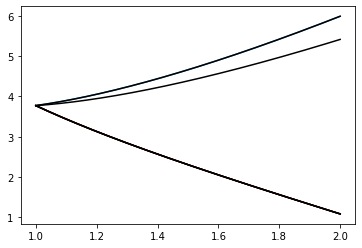

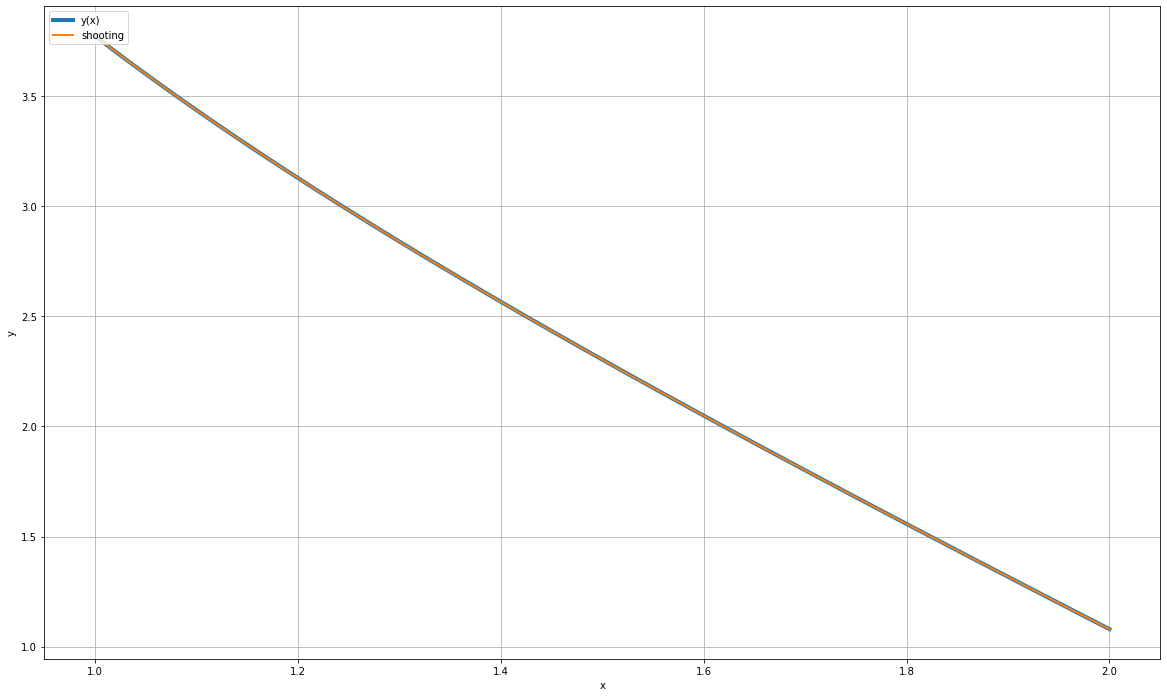

In [54]:
x_list = list(np.arange(interval[0], interval[1] + step / 2, step))

y = [y_lambda(x) for x in x_list]

plt.plot(x_list, y, label="y(x)", color='r')
plt.plot(x_list, RungeKutta(function, y2, y1, x_list, step), label="y(x)")

shooting_res = shooting(function, y1, y2, x_list, step, eps=0.000000000000001)

plt.figure(figsize=(20, 12))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_list, y, label="y(x)", linewidth=4)
plt.plot(x_list, shooting_res, label="shooting", linewidth=2)
plt.legend(loc=2)
None

## Оценка погрешности

In [55]:
def RungeRombergRichardson(Fh, Fkh):
    return Fh + (Fh - Fkh)/(0.5*0.5 - 1)

In [56]:
error = []
for i in range(len(y)):
    error.append(math.fabs(y[i] - RungeRombergRichardson(y[i], shooting_res[i])))
    
print('Погрешность с помошью метода Рунге-Ромберга:', error[-1])
print('Погрешность сравнения с точным решением:', abs(shooting_res[-1] - y2))

Погрешность с помошью метода Рунге-Ромберга: 3.497202527569243e-13
Погрешность сравнения с точным решением: 2.220446049250313e-16


# Конечно-разностный метод решения краевой задачи

In [57]:
def Progonka(arr):
    A = [[arr[i][j] for j in range(len(arr[i]))] for i in range(len(arr))]
    n = len(A)

    #   Формирование массивов чисел a, b, c, d _____________
    #   a = [a0, a1, a2, ..., a_n]
    a, b, c, d = [0], [arr[0][0]], [arr[0][1]], [arr[0][2]]
    for i in arr[1:-1]:
        a.append(i[0])
        b.append(i[1])
        c.append(i[2])
        d.append(i[3])

    a.append(arr[-1][0])
    b.append(arr[-1][1])
    c.append(0)
    d.append(arr[-1][2])

    for i in range(n):
        if math.fabs(b[i]) < math.fabs(a[i]) + math.fabs(c[i]):
            raise Exception

    #   Формирование массивов P, Q (Расчет значений) ((Прямой ход))

    P, Q = [-c[0] / b[0]], [d[0] / b[0]]

    for i in range(1, n):
        P.append(-c[i] / (b[i] + a[i] * P[i - 1]))
        Q.append((d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1]))

    #   Вычисление решения системы (Обратный ход)
    x = [Q[n - 1]]
    for i in range(1, n):
        x.append(P[n - 1 - i] * x[i - 1] + Q[n - 1 - i])

#     print('P:')
#     print(np.array(P))
#     print('Q:')
#     print(np.array(Q))

    x = reversed(x)
    return x

In [105]:
def finite_difference(p, q, f, ya, yb, x, h):
    n = len(x) - 2
    A = []
    A.append([-2 + h*h*q(x[1]), 1 + p(x[1])*h/2, h*h*f(x[1]) - (1 - p(x[1])*h/2)*ya])
    for k in range(2, n):
        a = [1 - p(x[k])*h/2, -2 + h*h*q(x[k]), 1 + p(x[k])*h/2, h*h*f(x[k])]
        A.append(a)
        
    A.append([1 - p(x[n])*h/2, -2 + h*h*q(x[n]), h*h*f(x[n]) - (1 + p(x[n])*h/2)*yb])
    
    print('A:')
    i = n-2
    j = -1
    b = []
    for q in A:
        b.append(q[-1])
        for w in range(j):
            print(0, end='\t')
        for w in q[:-1]:
            print(round(w, 4), end='\t')
        for w in range(i):
            print(0, end='\t')
            
        print()
        i -= 1
        j += 1
    
    print()
    print('b:', b)
    print()
    
    part_y = Progonka(A)
    
    y = [ya]
    y.extend(part_y)
    y.append(yb)
    
    print('y:', y)
    
    return y

In [106]:
f = lambda x: 0
p = lambda x: 0
q = lambda x: -2/x/x/(x+1)

interval = [1, 2]
h = step = 0.1
ya = 1 + 4 * math.log(2)
yb = -1 + 3 * math.log(2)

x = list(np.arange(interval[0], interval[1] + step / 2, step))
# Точное решение
# y_lambda = lambda x: -1 + 2/x + 2*(x + 1)/x * math.log(abs(x + 1))
y_lambda = lambda x: (-7*x*x + x*(24*math.log(2)**2 - 6*math.log(3) - 24*math.log(2)*math.log(3) + math.log(64)) + 14*(x+1)*math.log(x+1) + 14 + 24*math.log(2)**2 + math.log(64) - 24*math.log(2)*math.log(3) - 6*math.log(3))/(x*(7-12*math.log(3) + math.log(4096)))

A:
-2.0079	1.0	0	0	0	0	0	0	0	
1.0	-2.0063	1.0	0	0	0	0	0	0	
0	1.0	-2.0051	1.0	0	0	0	0	0	
0	0	1.0	-2.0043	1.0	0	0	0	0	
0	0	0	1.0	-2.0036	1.0	0	0	0	
0	0	0	0	1.0	-2.003	1.0	0	0	
0	0	0	0	0	1.0	-2.0026	1.0	0	
0	0	0	0	0	0	1.0	-2.0022	1.0	
0	0	0	0	0	0	0	1.0	-2.0019	

b: [-3.772588722239781, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0794415416798357]

y: [3.772588722239781, 3.437452125316627, 3.1293714286320924, 2.8410468647040736, 2.5673404992051987, 2.304549697053284, 2.049952849379782, 1.801515715796964, 1.5576960773206354, 1.317310513088841, 1.0794415416798357]


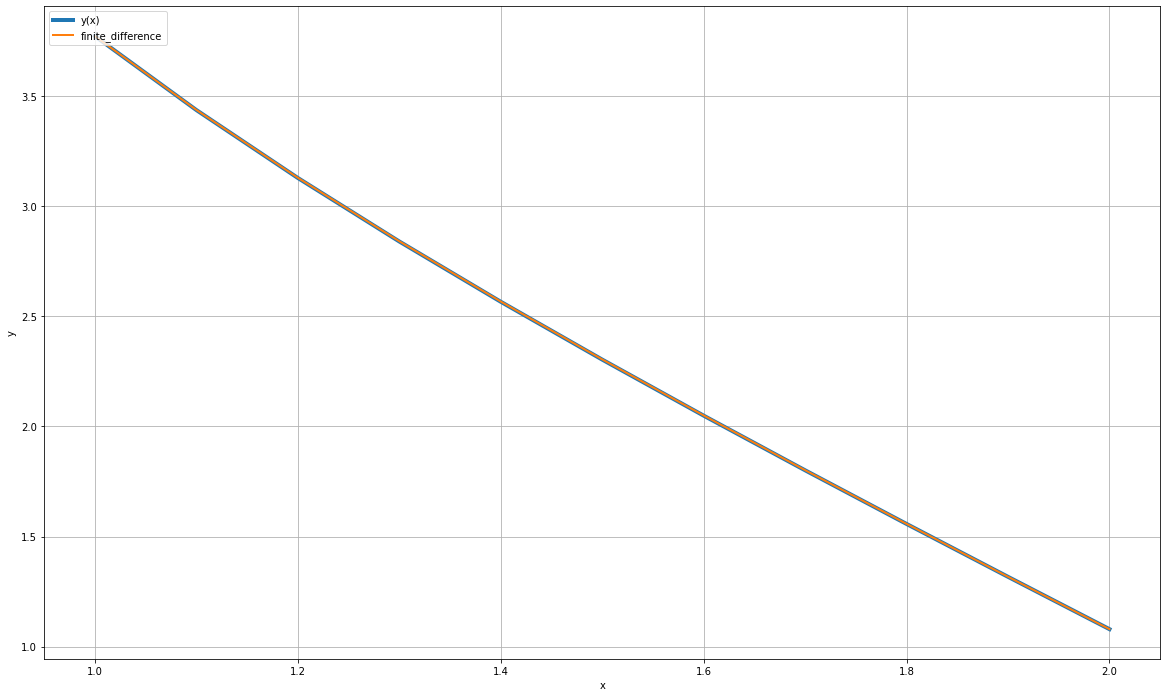

In [107]:
finite_difference_res = finite_difference(p, q, f, ya, yb, x, h)

y = [y_lambda(xi) for xi in x]

plt.figure(figsize=(20, 12))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x, y, label="y(x)", linewidth=4)
plt.plot(x, finite_difference_res, label="finite_difference", linewidth=2)
plt.legend(loc=2)
None

## Оценка погрешности

In [108]:
error = []
for i in range(len(y)):
    error.append(math.fabs(y[i] - RungeRombergRichardson(y[i], finite_difference_res[i])))
    
print('Погрешность с помошью метода Рунге-Ромберга:', error[-1])
print('Погрешность сравнения с точным решением:', abs(finite_difference_res[-1] - y2))

Погрешность с помошью метода Рунге-Ромберга: 1.5543122344752192e-15
Погрешность сравнения с точным решением: 0.0
